In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import datajoint as dj
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
sns.set_style('ticks', rc={'image.cmap': 'bwr'})

import os
import sys
import inspect

p = !pwd
p = os.path.dirname(os.path.dirname(p[0]))
if p not in sys.path:
    sys.path.append(p)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from cnn_sys_ident.mesonet.data import MultiDataset
from cnn_sys_ident.mesonet.parameters import Core, Readout, Model, RegPath, Fit
from cnn_sys_ident.mesonet import MODELS

Connecting aecker@52.202.15.166:3306


In [3]:
data_key = {'data_hash': 'cfcd208495d565ef66e7dff9f98764da'}

# Model comparison: arbitrary feature weights

In [4]:
model_rel = MODELS['HermiteSparse'] \
    & 'positive_feature_weights=False AND shared_biases=False'

In [8]:
def get_stats(model_rel, num_filters=None):
    if num_filters is None:
        num_filters = [8, 12, 16, 20, 24, 28, 32, 40, 48]
    test_corr, val_loss, num_filt = [], [], []
    for n in num_filters:
        filters_key = {'num_filters_2': n}
        rel = Fit() * model_rel & data_key & filters_key
        if len(rel):
            l, r = rel.fetch('val_loss', 'test_corr', order_by='val_loss', limit=5)
            val_loss.append(l)
            test_corr.append(r)
            num_filt.append(n)
            print('{}: {} (SD: {:.2f}), {} (SD: {:.4f})'.format(n, l, l.std(), r, r.std()))

    val_loss = np.array(val_loss)
    test_corr = np.array(test_corr)
    num_filt = np.array(num_filt)
    return val_loss, test_corr, num_filt

In [9]:
val_loss, test_corr, num_filt = get_stats(model_rel)

8: [3664.29 3666.25 3666.52 3668.48 3672.69] (SD: 2.85), [0.454361 0.449071 0.452207 0.449868 0.444532] (SD: 0.0033)
12: [3649.47 3655.34 3657.39 3657.8  3658.31] (SD: 3.26), [0.4543   0.456997 0.45786  0.459842 0.455869] (SD: 0.0019)
16: [3635.76 3639.64 3642.54 3653.76 3654.09] (SD: 7.48), [0.471959 0.466538 0.467967 0.459466 0.457765] (SD: 0.0053)
20: [3627.86 3636.93 3640.78 3642.4  3650.03] (SD: 7.25), [0.476702 0.468001 0.465529 0.477487 0.467746] (SD: 0.0050)
24: [3635.25 3637.17 3637.66 3638.95 3650.32] (SD: 5.36), [0.475134 0.473337 0.471952 0.469922 0.46028 ] (SD: 0.0052)
28: [3626.33 3633.96 3647.71 3650.6  3653.45] (SD: 10.46), [0.481902 0.471515 0.47113  0.466209 0.467611] (SD: 0.0055)
32: [3627.36 3628.81 3638.11 3639.11 3640.98] (SD: 5.64), [0.476858 0.479754 0.470225 0.477159 0.466539] (SD: 0.0049)
40: [3617.13 3624.37 3633.45 3634.85 3635.08] (SD: 7.12), [0.485852 0.484797 0.475146 0.482115 0.471319] (SD: 0.0057)
48: [3622.9  3631.89 3638.56 3641.85 3649.22] (SD: 8.95)

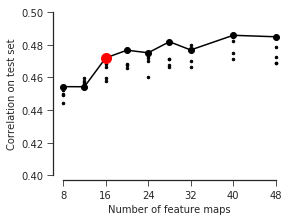

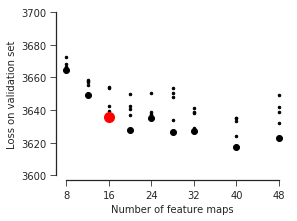

In [57]:
plt.figure(figsize=(4, 3))
plt.plot(num_filt, test_corr, '.k', ms=5)
plt.plot(num_filt, test_corr[:,0], 'o-k')
plt.plot(16, test_corr[num_filt==16,0], 'or', ms=10)
plt.ylim([0.4, 0.5])
plt.xlim([num_filt[0]-1, num_filt[-1]+1])
plt.xticks(num_filt[[0, 2, 4, 6, 7, 8]])
plt.xlabel('Number of feature maps')
plt.ylabel('Correlation on test set')
sns.despine(trim=True, offset=5)
plt.show()

plt.figure(figsize=(4, 3))
plt.plot(num_filt, val_loss, '.k', ms=5)
plt.plot(num_filt, val_loss[:,0], 'ok')
plt.plot(16, val_loss[num_filt==16,0], 'or', ms=10)
plt.ylim([3600, 3700])
plt.xlim([num_filt[0]-1, num_filt[-1]+1])
plt.xticks(num_filt[[0, 2, 4, 6, 7, 8]])
plt.xlabel('Number of feature maps')
plt.ylabel('Loss on validation set')
sns.despine(trim=True, offset=5)
plt.savefig('figures/model_comp.eps', format='eps')
plt.show()

In [98]:
print(test_corr.std(axis=1))

[0.00330661 0.00186452 0.0053334  0.00498127 0.0052098  0.00550104
 0.0049217  0.00566626 0.00623243]


In [115]:
sd = (val_loss[3].min() - val_loss[-1].min()) / val_loss[-1].std()
print('SDs from best validation loss: {:.2f}'.format(sd))

SDs from best validation loss: 0.55


### Disrtribution of correlations across neurons

In [4]:
import scipy.stats
model_rel = MODELS['HermiteSparse'] \
    & 'positive_feature_weights=False AND shared_biases=False AND num_filters_2=16'

In [24]:
key = (Fit() * model_rel).fetch(dj.key, order_by='val_loss')[1]
model = Fit().load_model(key)

INFO:tensorflow:Restoring parameters from /gpfs01/bethge/home/aecker/lab/projects/microns/cnn-sys-ident/checkpoints/aecker_mesonet_data/8c83bd2e8a8ea1b4f79c99edeabc3476/model.ckpt


In [25]:
data = model.base.data
inputs, responses = data.test()
feed_dict = {model.base.inputs: inputs, model.base.is_training: False}
predictions = model.base.evaluate(model.predictions, feed_dict=feed_dict)

In [27]:
rho = [scipy.stats.pearsonr(p, r)[0] for p, r in zip(predictions.T, responses.T)]

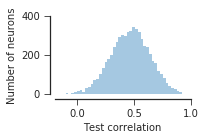

In [36]:
plt.figure(figsize=(3, 2))
sns.distplot(rho, bins=np.linspace(-0.2, 1, 50), kde=False)
plt.xlabel('Test correlation')
plt.ylabel('Number of neurons')
plt.xlim([-0.2, 1])
plt.ylim([0, 400])
sns.despine(offset=5)
plt.tight_layout()
plt.savefig('figures/test_correlations_distr.eps', format='eps')

# Control: positive feature weights

In [10]:
model_rel_p = MODELS['HermiteSparse'] \
    & 'positive_feature_weights=True AND shared_biases=False'
val_loss_p, test_corr_p, num_filt_p = get_stats(model_rel_p)

16: [3686.52 3703.72 3706.29 3715.03 3716.48] (SD: 10.73), [0.42934  0.424556 0.419554 0.41845  0.410165] (SD: 0.0064)
20: [3706.36 3715.03 3727.12 3729.32 3732.2 ] (SD: 9.77), [0.420268 0.410966 0.397063 0.395153 0.393807] (SD: 0.0104)
24: [3681.28 3694.78 3709.2  3717.98 3734.14] (SD: 18.28), [0.441365 0.424992 0.411171 0.41035  0.392984] (SD: 0.0162)
28: [3685.1  3697.15 3699.81 3705.01 3709.77] (SD: 8.35), [0.433358 0.423084 0.421646 0.417202 0.40419 ] (SD: 0.0095)
32: [3681.41 3698.09 3704.39 3714.82 3722.35] (SD: 14.13), [0.434432 0.422597 0.42031  0.415057 0.406342] (SD: 0.0092)
40: [3682.78 3686.39 3692.42 3695.04 3705.66] (SD: 7.89), [0.434058 0.43499  0.430706 0.424113 0.421978] (SD: 0.0052)
48: [3672.22 3684.22 3692.08 3703.06 3717.23] (SD: 15.46), [0.447082 0.432521 0.435794 0.421657 0.406907] (SD: 0.0136)


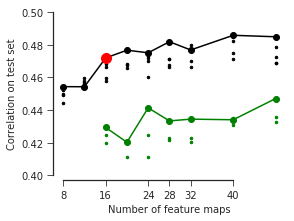

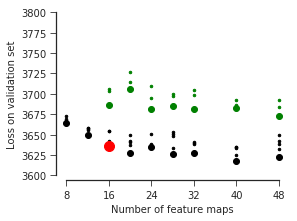

In [38]:
plt.figure(figsize=(4, 3))
plt.plot(num_filt, test_corr, '.k', ms=5)
plt.plot(num_filt, test_corr[:,0], 'o-k')
plt.plot(num_filt_p, test_corr_p[:,0], 'o-g')
plt.plot(num_filt_p, test_corr_p[:,:3], '.g', ms=5)
plt.plot(16, test_corr[num_filt==16,0], 'or', ms=10)
plt.ylim([0.4, 0.5])
plt.xlim([num_filt[0]-1, num_filt[-1]+1])
plt.xticks(num_filt[[0, 2, 4, 5, 6, 7]])
plt.xlabel('Number of feature maps')
plt.ylabel('Correlation on test set')
sns.despine(trim=True, offset=5)
plt.show()

plt.figure(figsize=(4, 3))
plt.plot(num_filt, val_loss, '.k', ms=5)
plt.plot(num_filt, val_loss[:,0], 'ok')
plt.plot(num_filt_p, val_loss_p[:,0], 'og')
plt.plot(num_filt_p, val_loss_p[:,:3], '.g', ms=5)
plt.plot(16, val_loss[num_filt==16,0], 'or', ms=10)
plt.ylim([3600, 3800])
plt.xlim([num_filt[0]-1, num_filt[-1]+1])
plt.xticks(num_filt[[0, 2, 4, 6, 7, 8]])
plt.xlabel('Number of feature maps')
plt.ylabel('Loss on validation set')
sns.despine(trim=True, offset=5)
plt.show()

# Control: shared biases

In [11]:
model_rel_b = MODELS['HermiteSparse'] \
    & 'positive_feature_weights=False AND shared_biases=True'
val_loss_b, test_corr_b, num_filt_b = get_stats(model_rel_b, num_filters=[16, 32, 48])

16: [3642.6  3648.26 3653.56 3659.58 3660.86] (SD: 6.87), [0.463854 0.461164 0.451291 0.450704 0.452306] (SD: 0.0055)
32: [3623.3  3624.61 3634.74 3637.8  3639.37] (SD: 6.72), [0.477075 0.477312 0.469392 0.469682 0.469932] (SD: 0.0037)
48: [3619.25 3624.69 3625.36 3628.04 3628.15] (SD: 3.24), [0.482117 0.481531 0.479573 0.480655 0.475419] (SD: 0.0024)


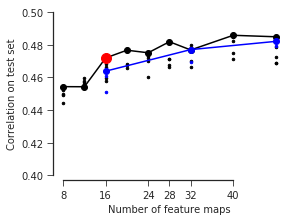

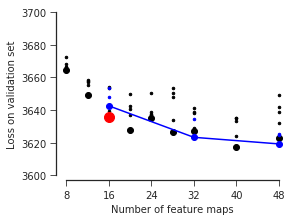

In [44]:
plt.figure(figsize=(4, 3))
plt.plot(num_filt, test_corr, '.k', ms=5)
plt.plot(num_filt, test_corr[:,0], 'o-k')
plt.plot(num_filt_b, test_corr_b[:,0], 'o-b')
plt.plot(num_filt_b, test_corr_b[:,:3], '.b', ms=5)
plt.plot(16, test_corr[num_filt==16,0], 'or', ms=10)
plt.ylim([0.4, 0.5])
plt.xlim([num_filt[0]-1, num_filt[-1]+1])
plt.xticks(num_filt[[0, 2, 4, 5, 6, 7]])
plt.xlabel('Number of feature maps')
plt.ylabel('Correlation on test set')
sns.despine(trim=True, offset=5)
plt.show()

plt.figure(figsize=(4, 3))
plt.plot(num_filt, val_loss, '.k', ms=5)
plt.plot(num_filt, val_loss[:,0], 'ok')
plt.plot(num_filt_b, val_loss_b[:,0], 'o-b')
plt.plot(num_filt_b, val_loss_b[:,:3], '.b', ms=5)
plt.plot(16, val_loss[num_filt==16,0], 'or', ms=10)
plt.ylim([3600, 3700])
plt.xlim([num_filt[0]-1, num_filt[-1]+1])
plt.xticks(num_filt[[0, 2, 4, 6, 7, 8]])
plt.xlabel('Number of feature maps')
plt.ylabel('Loss on validation set')
sns.despine(trim=True, offset=5)
plt.show()